In [1]:
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile


# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
for dirpath, dirnames, filenames in os.walk("/content/UTKFace"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 23708 images in '/content/UTKFace'.


In [5]:
for dirpath, dirnames, filenames in os.walk("/content/crop_part1"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 9780 images in '/content/crop_part1'.


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 4)

  # Read in the image and plot it using matplotlib
  fig, ax = plt.subplots(2,2)
  for i in range(4):
    img = mpimg.imread(target_folder + "/" + random_image[i])
    if(i<=1):
      ax[0][i].imshow(img)
      ax[0][i].set_title(random_image[i].split('.')[0])
      print(img.shape)
    else:
      ax[1][i-2].imshow(img)
      ax[1][i-2].set_title(random_image[i].split('.')[0])
      print(img.shape)

(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


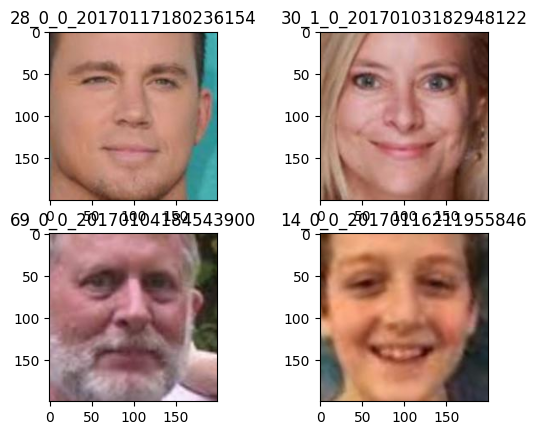

In [7]:
view_random_image('/content/UTKFace')

In [100]:
image_paths = []
age_labels = []
gender_labels = []
gender_age_labels = []

for filename in os.listdir("/content/UTKFace"):
    image_path = os.path.join("/content/UTKFace", filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    gender_age_labels.append([gender, age])

In [101]:
image_paths[:2]

['/content/UTKFace/29_1_1_20170116231359922.jpg.chip.jpg',
 '/content/UTKFace/23_0_4_20170117194059597.jpg.chip.jpg']

In [102]:
age_labels[:10]

[29, 23, 29, 31, 16, 52, 66, 62, 20, 26]

In [103]:
gender_labels[:10]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1]

In [104]:
gender_age_labels[:10]

[[1, 29],
 [0, 23],
 [0, 29],
 [0, 31],
 [1, 16],
 [0, 52],
 [0, 66],
 [0, 62],
 [1, 20],
 [1, 26]]

In [105]:
import numpy as np

In [18]:
def split_data(images, labels, train_size=0.6, validation_size=0.2, shuffle=True):
    np.random.seed(42)
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the sizes of training, validation, and test samples
    train_samples = int(size * train_size)
    validation_samples = int(size * validation_size)
    # 4. Split data into training, validation, and test sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:(train_samples + validation_samples)]], labels[indices[train_samples:(train_samples + validation_samples)]]
    x_test, y_test = images[indices[(train_samples + validation_samples):]], labels[indices[(train_samples + validation_samples):]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [107]:
# Splitting data into training, validation, and test sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(image_paths), np.array(gender_age_labels), train_size=0.6, validation_size=0.2)

In [109]:
x_train

array(['/content/UTKFace/5_0_1_20170103205158426.jpg.chip.jpg',
       '/content/UTKFace/4_1_0_20170109191952579.jpg.chip.jpg',
       '/content/UTKFace/27_0_1_20170117012811248.jpg.chip.jpg', ...,
       '/content/UTKFace/26_1_3_20170117174540872.jpg.chip.jpg',
       '/content/UTKFace/1_1_4_20161223225921227.jpg.chip.jpg',
       '/content/UTKFace/60_0_0_20170104170240505.jpg.chip.jpg'],
      dtype='<U55')

In [110]:
y_train

array([[ 0,  5],
       [ 1,  4],
       [ 0, 27],
       ...,
       [ 1, 26],
       [ 1,  1],
       [ 0, 60]])

In [111]:
import tensorflow as tf

In [112]:
def preprocess_image(image, target_size=(256, 256)):
    # Normalize pixel values to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Resize the image
    image = tf.image.resize(image, target_size)

    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)

    # Remove blurriness and noise using Gaussian blur
    image = tf.image.random_brightness(image, max_delta=0.5)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)  # Adjust contrast

    return image

def preprocess_data(image_path, gender_age_label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess_image(image)
    gender_label = gender_age_label[0]  # Extract gender label
    age_label = gender_age_label[1]     # Extract age label
    return image, (gender_label, age_label)


# def load_and_preprocess_image(image_path, label):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG images
#     image = preprocess_image(image)  # Preprocess the image
#     return image, label

In [113]:

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

TypeError: in user code:

    File "<ipython-input-17-01128a2128f0>", line 19, in preprocess_data  *
        image = tf.image.decode_jpeg(image, channels=3)

    TypeError: 'dict' object is not callable


In [19]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dropout, Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_size = (256, 256, 1)
inputs = Input(shape=input_size)
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis=3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu')(X)
dense_3 = Dense(128, activation='relu')(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)

# Gender output
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

# Age output
output_age = Dense(1, activation='linear', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_gender, output_age])


In [20]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "drive/MyDrive/model_weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_age_output_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [23]:
history = model.fit(train_dataset, batch_size = 32, epochs=15, validation_data = validation_dataset, callbacks=[checkpoint_callback])

Epoch 1/15
445/445 [==============================] - ETA: 0s - loss: 16.1753 - gender_output_loss: 0.6925 - age_output_loss: 15.4827 - gender_output_accuracy: 0.6699 - age_output_accuracy: 0.0453
Epoch 1: val_age_output_loss improved from inf to 13.20971, saving model to drive/MyDrive/model_weights.h5
445/445 [==============================] - 79s 148ms/step - loss: 16.1753 - gender_output_loss: 0.6925 - age_output_loss: 15.4827 - gender_output_accuracy: 0.6699 - age_output_accuracy: 0.0453 - val_loss: 13.7565 - val_gender_output_loss: 0.5468 - val_age_output_loss: 13.2097 - val_gender_output_accuracy: 0.7541 - val_age_output_accuracy: 0.0445
Epoch 2/15
445/445 [==============================] - ETA: 0s - loss: 11.8338 - gender_output_loss: 0.4336 - age_output_loss: 11.4002 - gender_output_accuracy: 0.7907 - age_output_accuracy: 0.0374
Epoch 2: val_age_output_loss improved from 13.20971 to 9.48416, saving model to drive/MyDrive/model_weights.h5
445/445 [==============================]

In [24]:
true_gender_labels = y_test[:,0]
true_age_labels = y_test[:,1]

In [25]:
from sklearn.metrics import mean_absolute_error, accuracy_score

def evaluate(model, dataset, y_true_age, y_true_gender):
    age_predictions = []

    # for batch in dataset:
    #   preds = model.predict(batch)
    #   age_predictions.extend(preds[1].reshape(-1))

    # preds = model.predict(dataset)
    # for i in range(len(dataset)):
    #   batch_preds = preds[i]
    #   age_predictions.extend(batch_preds[1].reshape(-1))

    preds = model.predict(dataset)

    # Extend age_predictions with the predictions for age
    age_predictions = preds[1].reshape(-1)

    gender_predictions = preds[0].reshape(-1)
    gender_predictions = [1 if pred>=0.5 else 0 for pred in gender_predictions]
    mae = mean_absolute_error(y_true_age, age_predictions)
    acc = accuracy_score(y_true_gender, gender_predictions)

    return {"Age_Prediction_MAE" : mae, "Gender_Prediction_Accuracy" : acc}



In [32]:
import pandas as pd
res_1 = pd.DataFrame(evaluate(model, test_dataset, true_age_labels, true_gender_labels), index=[0])
res_1

149/149 [==============================] - 10s 66ms/step


,Age_Prediction_MAE,Gender_Prediction_Accuracy
0,7.307422,0.877504


In [8]:
image_paths = []
age_labels = []
gender_labels = []
gender_age_labels = []

for filename in os.listdir("/content/UTKFace"):
    image_path = os.path.join("/content/UTKFace", filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    gender_age_labels.append([gender, age])

In [9]:
import pandas as pd

# Define age group buckets
age_buckets = [(1, 6), (7, 12), (13, 18), (19, 24), (25, 30), (31, 36), (37, 42), (43, 48), (49, 54), (55, 60), (61, 66), (67,72), (73,78), (79,84),(85,90),(90,95),(96,100)]

# Function to assign age group based on age
def assign_age_group(age):
    for i, (start, end) in enumerate(age_buckets):
        if start <= age <= end:
            return i + 1  # Adding 1 to start age group numbering from 1
    return len(age_buckets) + 1  # If age is beyond the specified buckets


data = {
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
}

df = pd.DataFrame(data)

# Apply age grouping function to create a new column 'age_group'
df['age_group'] = df['age'].apply(assign_age_group)


In [10]:
df.head()

,image,age,gender,age_group
0,/content/UTKFace/28_1_0_20170103182323771.jpg....,28,1,5
1,/content/UTKFace/53_1_0_20170110122634608.jpg....,53,1,9
2,/content/UTKFace/3_1_2_20161219160306229.jpg.c...,3,1,1
3,/content/UTKFace/1_1_0_20161219154510229.jpg.c...,1,1,1
4,/content/UTKFace/54_0_3_20170119201031709.jpg....,54,0,9


In [11]:
gender_age_labels = []
for i in range(len(df)):
  gender_age_labels.append([df.iloc[i]["gender"], df.iloc[i]["age_group"]])

In [12]:
gender_age_labels[:10]

[[1, 5],
 [1, 9],
 [1, 1],
 [1, 1],
 [0, 9],
 [1, 12],
 [1, 5],
 [0, 5],
 [0, 5],
 [1, 5]]

In [14]:
import numpy as np

In [15]:
np.array(df["image"])

array(['/content/UTKFace/28_1_0_20170103182323771.jpg.chip.jpg',
       '/content/UTKFace/53_1_0_20170110122634608.jpg.chip.jpg',
       '/content/UTKFace/3_1_2_20161219160306229.jpg.chip.jpg', ...,
       '/content/UTKFace/39_1_1_20170113000820292.jpg.chip.jpg',
       '/content/UTKFace/41_1_1_20170117135029687.jpg.chip.jpg',
       '/content/UTKFace/40_0_3_20170117154542505.jpg.chip.jpg'],
      dtype=object)

In [16]:
len(np.array(df["image"])), len(np.array(gender_age_labels))

(23708, 23708)

In [19]:
# Splitting data into training, validation, and test sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(image_paths), np.array(gender_age_labels), train_size=0.6, validation_size=0.2)

In [20]:
x_train

array(['/content/UTKFace/25_1_1_20170116171043499.jpg.chip.jpg',
       '/content/UTKFace/44_0_1_20170113185004294.jpg.chip.jpg',
       '/content/UTKFace/66_0_0_20170111222127534.jpg.chip.jpg', ...,
       '/content/UTKFace/15_1_2_20170104013425867.jpg.chip.jpg',
       '/content/UTKFace/56_1_0_20170110141043329.jpg.chip.jpg',
       '/content/UTKFace/20_0_0_20170113180905699.jpg.chip.jpg'],
      dtype='<U55')

In [21]:
def preprocess_image(image, target_size=(256, 256)):
    # Normalize pixel values to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Resize the image
    image = tf.image.resize(image, target_size)

    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)

    # Remove blurriness and noise using Gaussian blur
    image = tf.image.random_brightness(image, max_delta=0.5)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)  # Adjust contrast

    return image

def preprocess_data(image_path, gender_age_label):
    image_ = tf.io.read_file(image_path)
    print(type(image_))
    print(type(image_path))
    image_ = tf.image.decode_jpeg(image_, channels=3)
    image_ = preprocess_image(image_)
    gender_label = gender_age_label[0]  # Extract gender label
    age_label = gender_age_label[1]     # Extract age label
    return image_, (gender_label, age_label)


# def load_and_preprocess_image(image_path, label):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG images
#     image = preprocess_image(image)  # Preprocess the image
#     return image, label

In [23]:
import tensorflow as tf

In [24]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>


In [25]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dropout, Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_size = (256, 256, 1)
inputs = Input(shape=input_size)
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis=3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu')(X)
dense_3 = Dense(128, activation='relu')(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)

# Gender output
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

# Age output
output_age = Dense(1, activation='linear', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_gender, output_age])

In [26]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "drive/MyDrive/model_weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_age_output_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [28]:
history = model.fit(train_dataset, batch_size = 32, epochs=15, validation_data = validation_dataset, callbacks=[checkpoint_callback])

Epoch 1/15
  2/445 [..............................] - ETA: 1:24:34 - loss: 41.9871 - gender_output_loss: 2.1427 - age_output_loss: 39.8444 - gender_output_accuracy: 0.5156 - age_output_accuracy: 0.0781  

KeyboardInterrupt: 

In [70]:
x_train[0]

'/content/UTKFace/5_0_1_20170103205158426.jpg.chip.jpg'

In [68]:
y_train[1][0]

1